# Modelando as queimadas no estado do Amazonas com um modelo diferente para cada mês

O objetivo aqui é testar a ideia de criar um modelo de predição para cada diferente mês do ano. Essa ideia surgiu da observação de que os modelos lineares tem muita dificuldade de interpretar a variável de mês.

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Auxiliar Functions

In [2]:
def clean_x_axis(X_test):
    date_list = []
    year_list = X_test['year'].values
    month_list = X_test['month'].values
        
    for i in range(len(X_test)):
        date_list.append(str(year_list[i])[2:] + '-' + str(month_list[i]))
        
    return date_list

## Load datasets

In [3]:
mode = 'local'

if mode == "local":
    agregated_data = pd.read_csv("..\\..\\dados\\Feature Engineered\\agregated_data.csv")
elif mode == "colab":
    agregated_data = pd.read_csv("https://raw.githubusercontent.com/Liga-IA/Amazon-Fires-Regressions/main/dados/Feature%20Engineered/agregated_data.csv")
    
agregated_data['state'].unique()

array(['acre', 'alagoas', 'amapa', 'amazonas', 'bahia', 'ceara',
       'distrito federal', 'espirito santo', 'goias', 'maranhao',
       'mato grosso', 'minas gerais', 'para', 'paraiba', 'pernambuco',
       'rio de janeiro', 'rondonia', 'roraima', 'santa catarina',
       'sao paulo', 'sergipe', 'tocantins', 'piaui',
       'rio grande do norte', 'rio grande do sul', 'mato grosso do sul',
       'parana'], dtype=object)

## Prepare Data

In [4]:
state = agregated_data.loc[agregated_data['state'] == 'amazonas']
print("state len:", len(state))
state = state.sort_values('month', kind="mergesort").sort_values('year', kind="mergesort")

state len: 252


In [5]:
input_features = ['year', 'month']
target_feature = ['incidents']

X, y = state[input_features], state[target_feature]

## Linear Modelling

### Linear Regression

334.74 0.788


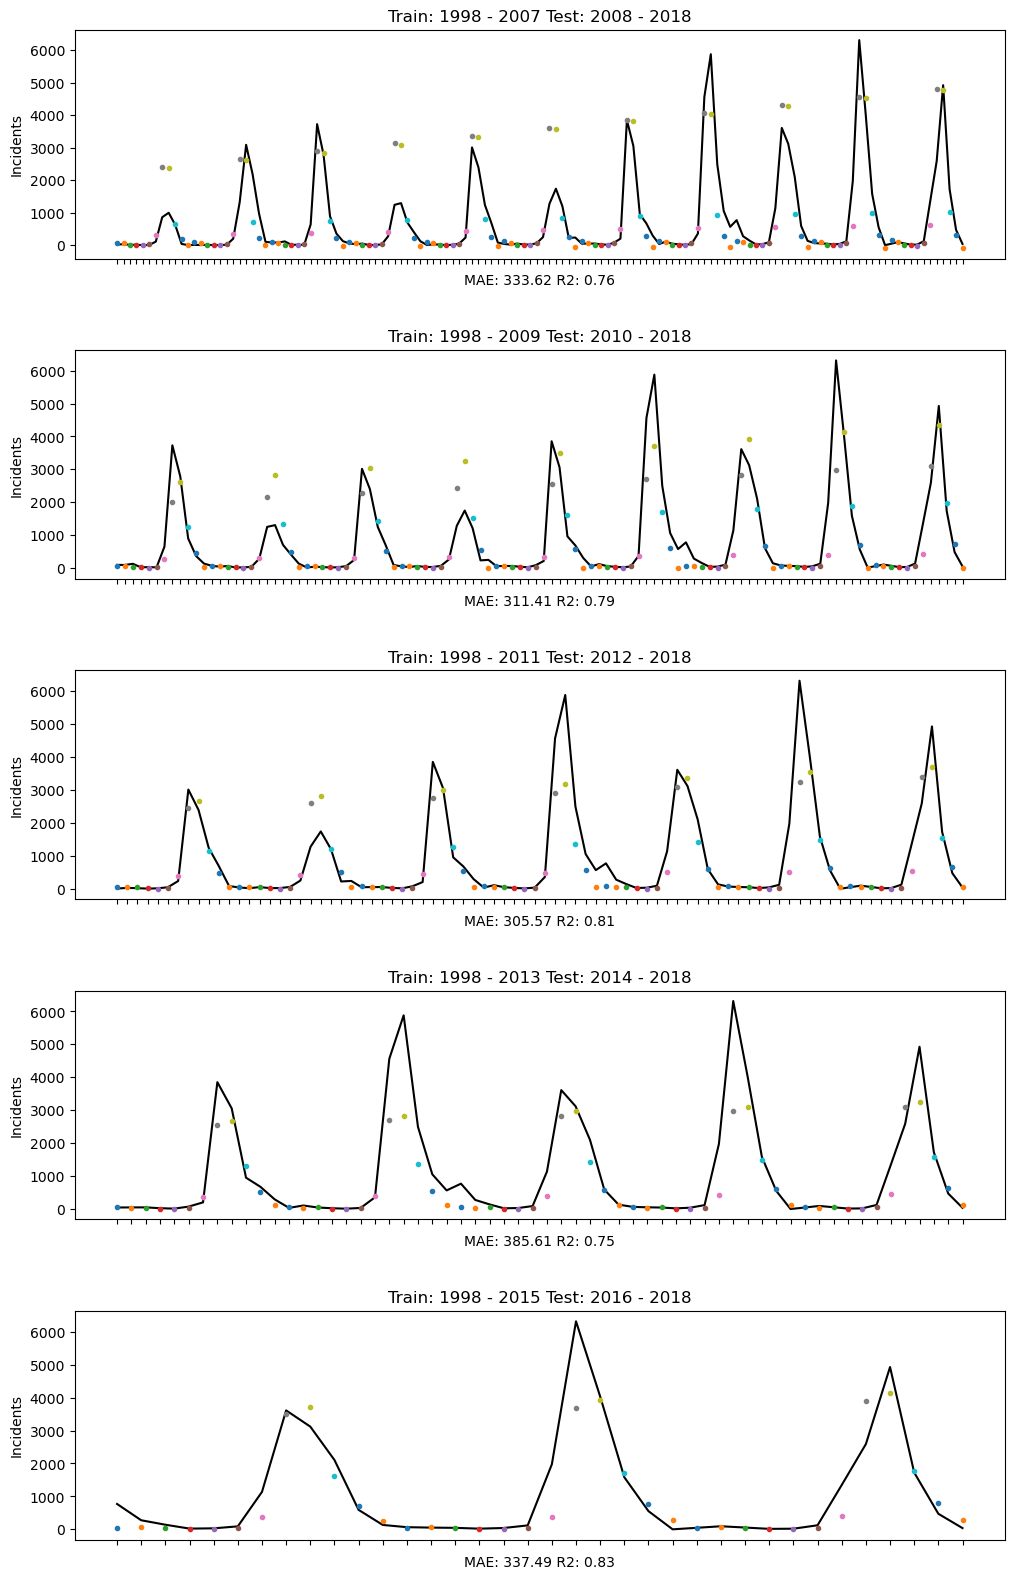

In [6]:
plt.rcParams['figure.figsize'] = [12, 4*5]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['figure.subplot.hspace'] = 0.4 

fig, axs = plt.subplots(5)

try_el_nino_and_la_nina_effect = False

model_maes, model_r2s = [], []
i = 0
for cut_year in range(2008, 2017, 2):
    X_train, X_test = X.loc[X['year'] < cut_year], X.loc[X['year'] >= cut_year]
    y_train, y_test = y.loc[X['year'] < cut_year], y.loc[X['year'] >= cut_year]
    
    axs[i].plot(np.array(clean_x_axis(X_test)), y_test, '-', label=f"Dados Reais", color="Black")
    
    maes, ys, ycs = [], [], []
    info_to_r2 = {
            "year": [],
            "month": [],
            "predicted_value": [],
            "real_value": [],
        }
    for month in range(1, 13, 1):
        lr = LinearRegression()
        lr.fit(X_train.loc[X_train['month'] == month], y_train.loc[X_train['month'] == month])
    
        y_predicted = lr.predict(X_test.loc[X_test['month'] == month])
        
        if try_el_nino_and_la_nina_effect:
            for y_1 in range(cut_year, 2019):
                if state.loc[state['year'] == y_1]['el nino'].iloc[0] >= 2:
                    y_predicted[y_1 - cut_year] *= 1 + (state.loc[state['year'] == y_1]['el nino'].iloc[0]/10)
                if state.loc[state['year'] == y_1]['la nina'].iloc[0] >= 2:
                    y_predicted[y_1 - cut_year] *= 1 - (state.loc[state['year'] == y_1]['la nina'].iloc[0]/10)
        
        for y_1 in range(cut_year, 2019):    
            info_to_r2['year'].append(y_1)
            info_to_r2['month'].append(month)
            info_to_r2['predicted_value'].append(y_predicted[y_1 - cut_year])
            info_to_r2['real_value'].append(y_test.loc[X_test['month'] == month].loc[X_test['year'] == y_1].values[0])
                
        for k in range(len(y_test.loc[X_test['month'] == month])):
            ys.append(y_test.loc[X_test['month'] == month].values[k])
            ycs.append(y_predicted[k])
            
        maes.append(mean_absolute_error(y_test.loc[X_test['month'] == month], y_predicted))
        
        axs[i].plot(np.array(clean_x_axis(X_test.loc[X_test['month'] == month])), y_predicted, '.', label=f"{month}")
    
    info_to_r2 = pd.DataFrame(info_to_r2).sort_values('month', kind="mergesort").sort_values('year', kind="mergesort")
    
    axs[i].axes.xaxis.set_ticklabels([])

    axs[i].set_title(f"Train: 1998 - {cut_year - 1} Test: {cut_year} - 2018")
    axs[i].set_ylabel("Incidents")
    axs[i].set_xlabel(f"MAE: {np.round(np.mean(maes), 2)} R2: {np.round(r2_score(ys, ycs), 2)}")
    model_maes.append(np.round(np.mean(maes), 2))
    model_r2s.append(np.round(r2_score(info_to_r2['real_value'], info_to_r2['predicted_value']), 2))
    i += 1

print(np.mean(model_maes), np.mean(model_r2s))

## Admitindo que o El nino e La nina tenham um efeito de 10% * força do evento sobre as quantidades de queimadas

In [7]:
input_features = ['year', 'month']
target_feature = ['corrected_incidents']

aux = np.zeros(len(state))
for i in range(len(state)):
    if state['el nino'].iloc[i] >= 2:
        aux[i] = state['incidents'].iloc[i] / (1 + state['el nino'].iloc[i]/10)
    elif state['la nina'].iloc[i] >= 2:
        aux[i] = state['incidents'].iloc[i] / (1 - state['la nina'].iloc[i]/10)
    else:
        aux[i] = state['incidents'].iloc[i]
state['corrected_incidents'] = aux
X, y_corrected, y_real = state[input_features], state[target_feature], state['incidents']

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4*5]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['figure.subplot.hspace'] = 0.4 

fig, axs = plt.subplots(5)

model_maes, model_r2s = [], []
i = 0
for cut_year in range(2008, 2017, 2):
    X_train, X_test = X.loc[X['year'] < cut_year], X.loc[X['year'] >= cut_year]
    y_train, y_test = y_corrected.loc[X['year'] < cut_year], y_real.loc[X['year'] >= cut_year]
    
    axs[i].plot(np.array(clean_x_axis(X_test)), y_test, '.', label=f"Dados Reais", color="Black")
    
    maes, ys, ycs = [], [], []
    info_to_r2 = {
            "year": [],
            "month": [],
            "predicted_value": [],
            "real_value": [],
        }
    for month in range(1, 13, 1):
        lr = LinearRegression()
        lr.fit(X_train.loc[X_train['month'] == month], y_train.loc[X_train['month'] == month])
    
        y_predicted = lr.predict(X_test.loc[X_test['month'] == month])
        
        for y_1 in range(cut_year, 2019):
                if state.loc[state['year'] == y_1]['el nino'].iloc[0] >= 2:
                    y_predicted[y_1 - cut_year] *= (1 + (state.loc[state['year'] == y_1]['el nino'].iloc[0]/10))
                if state.loc[state['year'] == y_1]['la nina'].iloc[0] >= 2:
                    y_predicted[y_1 - cut_year] *= (1 - (state.loc[state['year'] == y_1]['la nina'].iloc[0]/10))
                    
        for y_1 in range(cut_year, 2019):    
            info_to_r2['year'].append(y_1)
            info_to_r2['month'].append(month)
            info_to_r2['predicted_value'].append(y_predicted[y_1 - cut_year])
            info_to_r2['real_value'].append(y_test.loc[X_test['month'] == month].loc[X_test['year'] == y_1].values[0])
                
        for k in range(len(y_test.loc[X_test['month'] == month])):
            ys.append(y_test.loc[X_test['month'] == month].values[k])
            ycs.append(y_predicted[k])
            
        maes.append(mean_absolute_error(y_test.loc[X_test['month'] == month], y_predicted))
        
        axs[i].plot(np.array(clean_x_axis(X_test.loc[X_test['month'] == month])), y_predicted, '.', label=f"{month}")
    
    info_to_r2 = pd.DataFrame(info_to_r2).sort_values('month', kind="mergesort").sort_values('year', kind="mergesort")
    
    axs[i].axes.xaxis.set_ticklabels([])

    axs[i].set_title(f"Train: 1998 - {cut_year - 1} Test: {cut_year} - 2018")
    axs[i].set_ylabel("Incidents")
    axs[i].set_xlabel(f"MAE: {np.round(np.mean(maes), 2)} R2: {np.round(r2_score(ys, ycs), 2)}")
    model_maes.append(np.round(np.mean(maes), 2))
    model_r2s.append(np.round(r2_score(info_to_r2['real_value'], info_to_r2['predicted_value']), 2))
    i += 1

print(np.mean(model_maes), np.mean(model_r2s))

309.42199999999997 0.82
